<a href="https://colab.research.google.com/github/ash200309/Stock_prediction/blob/main/Stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stock Market Prediction using Numerical and Textual Analysis**
## **Notebook by [Ansh Arora](https://www.linkedin.com/in/ansh-arora-1648a4226/)**

### **Description**

Stock market prediction is the act of trying to determine the future value of a company stock or other financial instrument traded on an exchange. The successful prediction of a stock's future price could yield significant profit. The efficient-market hypothesis suggests that stock prices reflect all currently available information and any price changes that are not based on newly revealed information thus are inherently unpredictable. Others disagree and those with this viewpoint possess myriad methods and technologies which purportedly allow them to gain future price information.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing Libraries

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost
import lightgbm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
!pip install pmdarima

  Using cached pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.1 MB)


### Loading datasets

In [ ]:
stock_df=pd.read_csv("/content/drive/MyDrive/data/stock_data.csv")
stock_df

,Date,Open,High,Low,Close,Volume
0,01-03-2006,39.69,41.22,38.79,40.91,24232729
1,01-04-2006,41.22,41.90,40.77,40.97,20553479
2,01-05-2006,40.93,41.73,40.85,41.53,12829610
3,01-06-2006,42.88,43.57,42.80,43.21,29422828
4,01-09-2006,43.10,43.66,42.82,43.42,16268338
...,...,...,...,...,...,...
3014,12/22/2017,71.42,71.87,71.22,71.58,10979165
3015,12/26/2017,70.94,71.39,69.63,69.86,8542802
3016,12/27/2017,69.77,70.49,69.69,70.06,6345124
3017,12/28/2017,70.12,70.32,69.51,69.82,7556877


In [ ]:
cols = ['Date','Category','News']
news_df= pd.read_csv('/content/drive/MyDrive/data/india-news-headlines.csv', names = cols)
news_df

,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa
...,...,...,...
3650966,20220331,city.srinagar,J&K sacks 2 cops; 3 other employees over terro...
3650967,20220331,entertainment.hindi.bollywood,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
3650968,20220331,city.trichy,As Covid-19 cases drop to nil in southern dist...
3650969,20220331,city.erode,Tamil Nadu sees marginal rise of Covid cases w...


In [ ]:
news_df.drop(0, inplace=True)
news_df.drop('Category', axis = 1, inplace=True)
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 1 to 3650970
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Date    object
 1   News    object
dtypes: object(2)
memory usage: 55.7+ MB


### Let's equate the two datasets first

In [ ]:
stock_df['Date']= pd.to_datetime(stock_df['Date'])
stock_df.head()

,Date,Open,High,Low,Close,Volume
0,2006-01-03,39.69,41.22,38.79,40.91,24232729
1,2006-01-04,41.22,41.90,40.77,40.97,20553479
2,2006-01-05,40.93,41.73,40.85,41.53,12829610
3,2006-01-06,42.88,43.57,42.80,43.21,29422828
4,2006-01-09,43.10,43.66,42.82,43.42,16268338


In [ ]:
stock_df.tail()

,Date,Open,High,Low,Close,Volume
3014,2017-12-22,71.42,71.87,71.22,71.58,10979165
3015,2017-12-26,70.94,71.39,69.63,69.86,8542802
3016,2017-12-27,69.77,70.49,69.69,70.06,6345124
3017,2017-12-28,70.12,70.32,69.51,69.82,7556877
3018,2017-12-29,69.79,70.13,69.43,69.85,6613070


In [ ]:
news_df['Date']=pd.to_datetime(news_df['Date'],format='%Y%m%d')
news_df.head(3)

,Date,News
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-02,Fissures in Hurriyat over Pak visit
3,2001-01-02,America's unwanted heading for India?


#### Selecting dataset only from the below timeline.
#### 2006-01-03 to 2017-12-29

In [ ]:
news_df.set_index('Date', inplace=True)

In [ ]:
start_date="2006-01-03"
end_date="2017-12-29"
sliced_df = news_df.loc[start_date:end_date]

In [ ]:
sliced_df.head()

,News
Date,
2006-01-03,Furore over road model patent
2006-01-03,Sahara's offer to unleash fresh fare war
2006-01-03,MRTPC steps into fashion fracas with FDCI
2006-01-03,Trai issues paper on convergence
2006-01-03,Gudiya's mute story ends in death


In [ ]:
sliced_df.tail()

,News
Date,
2017-12-29,Unplanned growth; poorly enforced regulations ...
2017-12-29,Hours later; it's business as usual for other ...
2017-12-29,Resto-bar owners booked; jurists say probe bab...
2017-12-29,29-year-old's life snuffed out an hour after s...
2017-12-29,29-year-old's life snuffed out an hour after s...


In [ ]:
sliced_df.shape

(2415703, 1)

In [ ]:
sliced_df.duplicated().sum()

192417

Gouping headlines for each day and dropping duplicates

In [ ]:
sliced_df['News'] = sliced_df.groupby(['Date']).transform(lambda x : ' '.join(x))
sliced_df = sliced_df.drop_duplicates()
sliced_df.shape

(4379, 1)

Cleaning the news data

In [ ]:
sliced_df.replace("[^a-zA-Z']"," ",regex=True,inplace=True)
sliced_df["News"].head(5)

Date
2006-01-03    Furore over road model patent Sahara's offer t...
2006-01-04    Dual citizenship for Pravasi Indians Carlos Mo...
2006-01-05    Sania sizzles in doubles PHL II promises thril...
2006-01-06       action babes Hockey  Hyd Sultans laid low b...
2006-01-07    Caught after   uncertain days For Rajnath  RSS...
Name: News, dtype: object

In [ ]:
sliced_df.reset_index(inplace=True)

In [ ]:
news_df2=sliced_df.copy()

## EDA (stock Dataframe)

In [ ]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3019 non-null   datetime64[ns]
 1   Open    3019 non-null   float64       
 2   High    3019 non-null   float64       
 3   Low     3019 non-null   float64       
 4   Close   3019 non-null   float64       
 5   Volume  3019 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 141.6 KB


In [ ]:
stock_df.describe()

,Open,High,Low,Close,Volume
count,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03
mean,28.426479,28.766532,28.066558,28.412726,2.158391e+07
std,13.257242,13.356692,13.157326,13.258163,1.926231e+07
min,9.100000,9.480000,8.940000,8.950000,1.939061e+06
25%,16.175000,16.385000,15.970000,16.130000,1.248025e+07
50%,27.180000,27.490000,26.820000,27.100000,1.732130e+07
75%,36.655000,37.035000,36.305000,36.635000,2.512757e+07
max,73.020000,73.250000,72.460000,72.930000,4.382317e+08


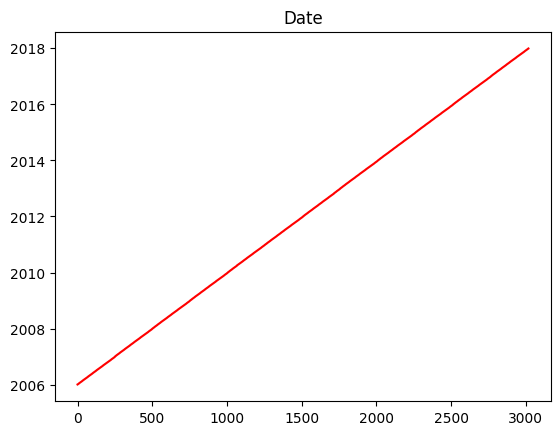

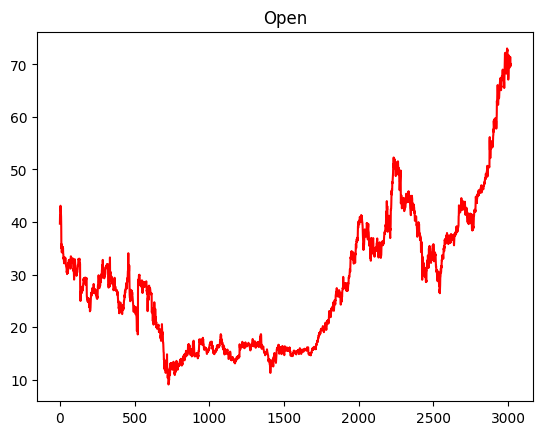

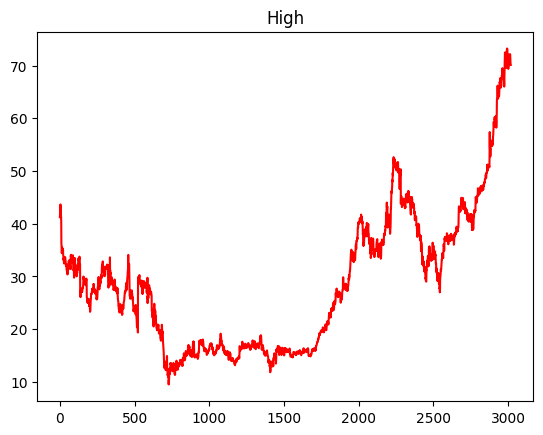

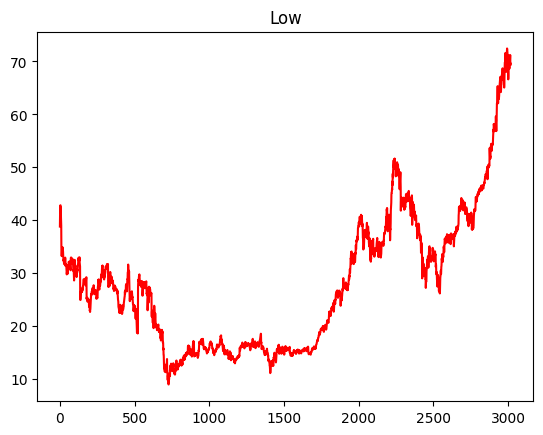

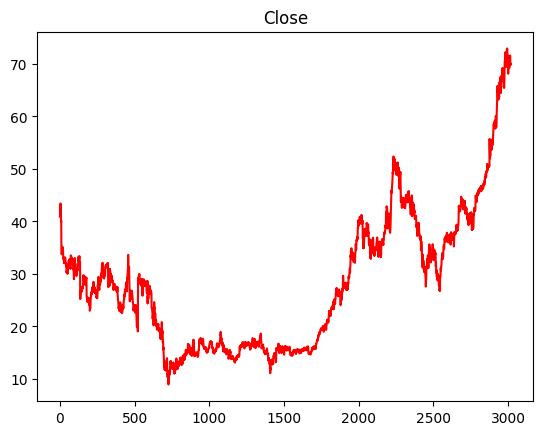

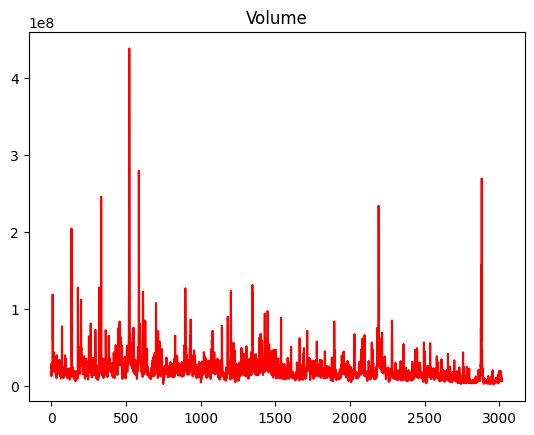

In [ ]:
for column in stock_df.columns:
  stock_df[column].plot(color='r')
  plt.title(column)
  plt.show()

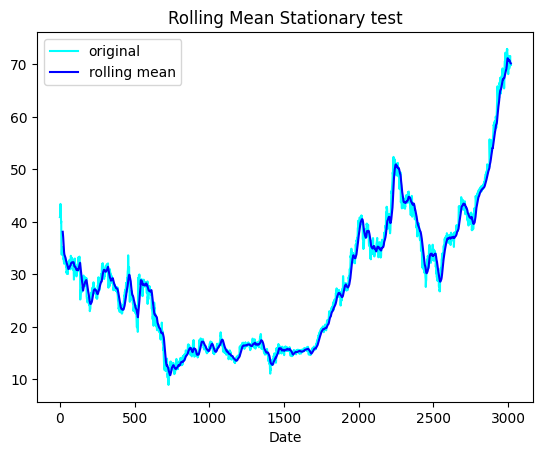

Results of ADF test
ADF Test Statistic : 0.9478981895596861
p-value : 0.9936846299287978
Weak evidence against null hypothesis, time series is non-stationary 


In [ ]:
def test_stationarity(timeseries):

 rolmean = timeseries.rolling(20).mean()
 plt.plot(timeseries, color = 'cyan', label = 'original')
 plt.plot(rolmean, color = 'b', label = 'rolling mean')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean Stationary test')
 plt.show(block = False)

 print('Results of ADF test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(stock_df['Close'])

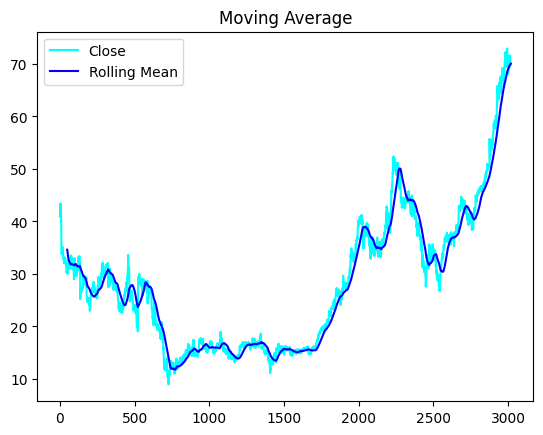

In [ ]:
close = stock_df['Close']
ma = close.rolling(window = 50).mean()

stock_df['Close'].plot(color = 'cyan', label = 'Close')
ma.plot(color = 'b', label = 'Rolling Mean')
plt.legend()
plt.title("Moving Average")
plt.show()

### Merging Dataframes

In [ ]:
merged_df = pd.merge(stock_df, news_df2, how='inner', on='Date')
merged_df.head()

,Date,Open,High,Low,Close,Volume,News
0,2006-01-03,39.69,41.22,38.79,40.91,24232729,Furore over road model patent Sahara's offer t...
1,2006-01-04,41.22,41.90,40.77,40.97,20553479,Dual citizenship for Pravasi Indians Carlos Mo...
2,2006-01-05,40.93,41.73,40.85,41.53,12829610,Sania sizzles in doubles PHL II promises thril...
3,2006-01-06,42.88,43.57,42.80,43.21,29422828,action babes Hockey Hyd Sultans laid low b...
4,2006-01-09,43.10,43.66,42.82,43.42,16268338,Straight Answers The Mahatma's tale Mysterious...


In [ ]:
def Subjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def Polarity(text):
  return  TextBlob(text).sentiment.polarity

merged_df['Subjectivity'] = merged_df['News'].apply(Subjectivity)
merged_df['Polarity'] = merged_df['News'].apply(Polarity)
merged_df

,Date,Open,High,Low,Close,Volume,News,Subjectivity,Polarity
0,2006-01-03,39.69,41.22,38.79,40.91,24232729,Furore over road model patent Sahara's offer t...,0.449242,0.105296
1,2006-01-04,41.22,41.90,40.77,40.97,20553479,Dual citizenship for Pravasi Indians Carlos Mo...,0.427236,0.073937
2,2006-01-05,40.93,41.73,40.85,41.53,12829610,Sania sizzles in doubles PHL II promises thril...,0.381269,0.018281
3,2006-01-06,42.88,43.57,42.80,43.21,29422828,action babes Hockey Hyd Sultans laid low b...,0.404464,0.069763
4,2006-01-09,43.10,43.66,42.82,43.42,16268338,Straight Answers The Mahatma's tale Mysterious...,0.413450,0.052480
...,...,...,...,...,...,...,...,...,...
3014,2017-12-22,71.42,71.87,71.22,71.58,10979165,Six winners of aptitude challenge go on Nasa t...,0.397826,0.048103
3015,2017-12-26,70.94,71.39,69.63,69.86,8542802,'Aiyaary' trailer launch in Mumbai was a grand...,0.404418,0.083670
3016,2017-12-27,69.77,70.49,69.69,70.06,6345124,Class girl found hanging in hostel room Mor...,0.396810,0.033057
3017,2017-12-28,70.12,70.32,69.51,69.82,7556877,The balance of life IIT Kharagpur Tata Medica...,0.388637,0.045662


In [ ]:
sen = SentimentIntensityAnalyzer()

merged_df['Compound'] = [sen.polarity_scores(row)['compound'] for row in merged_df['News']]
merged_df['Negative'] = [sen.polarity_scores(row)['neg'] for row in merged_df['News']]
merged_df['Neutral'] = [sen.polarity_scores(row)['neu'] for row in merged_df['News']]
merged_df['Positive'] = [sen.polarity_scores(row)['pos'] for row in merged_df['News']]
merged_df

,Date,Open,High,Low,Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2006-01-03,39.69,41.22,38.79,40.91,24232729,Furore over road model patent Sahara's offer t...,0.449242,0.105296,-0.9988,0.193,0.697,0.111
1,2006-01-04,41.22,41.90,40.77,40.97,20553479,Dual citizenship for Pravasi Indians Carlos Mo...,0.427236,0.073937,-0.9981,0.168,0.729,0.103
2,2006-01-05,40.93,41.73,40.85,41.53,12829610,Sania sizzles in doubles PHL II promises thril...,0.381269,0.018281,-0.9963,0.146,0.757,0.097
3,2006-01-06,42.88,43.57,42.80,43.21,29422828,action babes Hockey Hyd Sultans laid low b...,0.404464,0.069763,-0.9927,0.147,0.752,0.102
4,2006-01-09,43.10,43.66,42.82,43.42,16268338,Straight Answers The Mahatma's tale Mysterious...,0.413450,0.052480,-0.9982,0.146,0.773,0.081
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3014,2017-12-22,71.42,71.87,71.22,71.58,10979165,Six winners of aptitude challenge go on Nasa t...,0.397826,0.048103,-0.9999,0.171,0.720,0.108
3015,2017-12-26,70.94,71.39,69.63,69.86,8542802,'Aiyaary' trailer launch in Mumbai was a grand...,0.404418,0.083670,-0.9999,0.155,0.731,0.115
3016,2017-12-27,69.77,70.49,69.69,70.06,6345124,Class girl found hanging in hostel room Mor...,0.396810,0.033057,-1.0000,0.166,0.735,0.099
3017,2017-12-28,70.12,70.32,69.51,69.82,7556877,The balance of life IIT Kharagpur Tata Medica...,0.388637,0.045662,-0.9999,0.166,0.731,0.103


In [ ]:
df = merged_df[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
df

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,40.91,0.449242,0.105296,-0.9988,0.193,0.697,0.111
1,40.97,0.427236,0.073937,-0.9981,0.168,0.729,0.103
2,41.53,0.381269,0.018281,-0.9963,0.146,0.757,0.097
3,43.21,0.404464,0.069763,-0.9927,0.147,0.752,0.102
4,43.42,0.413450,0.052480,-0.9982,0.146,0.773,0.081
...,...,...,...,...,...,...,...
3014,71.58,0.397826,0.048103,-0.9999,0.171,0.720,0.108
3015,69.86,0.404418,0.083670,-0.9999,0.155,0.731,0.115
3016,70.06,0.396810,0.033057,-1.0000,0.166,0.735,0.099
3017,69.82,0.388637,0.045662,-0.9999,0.166,0.731,0.103


In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
df = pd.DataFrame(sc.fit_transform(df))
df.columns = df.columns
df.index = df.index
df.head()

,0,1,2,3,4,5,6
0,0.499531,0.659711,0.464090,0.00060,0.623656,0.347170,0.349727
1,0.500469,0.584335,0.375397,0.00095,0.489247,0.467925,0.306011
2,0.509222,0.426893,0.217985,0.00185,0.370968,0.573585,0.273224
3,0.535480,0.506339,0.363592,0.00365,0.376344,0.554717,0.300546
4,0.538762,0.537119,0.314710,0.00090,0.370968,0.633962,0.185792


In [ ]:
x = df.drop(0, axis=1)
y =df[0]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 0)
x_train.shape

(2415, 6)

### Random Forest

In [ ]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
y_pred=rf.predict(x_test)

In [ ]:
print("Mean Squared error is: ",mean_squared_error(y_pred,y_test))

Mean Squared error is:  0.026980177336953133


### XGBoost

In [ ]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = xgb.predict(x_test)
print("Mean Squared error is: ",mean_squared_error(y_pred,y_test))

Mean Squared error is:  0.030405214423579963


### Light LGM Regressor

In [ ]:
lgb = lightgbm.LGBMRegressor()
lgb.fit(x_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 980
[LightGBM] [Info] Number of data points in the train set: 2415, number of used features: 6
[LightGBM] [Info] Start training from score 0.306115


LGBMRegressor()

In [ ]:
y_pred = lgb.predict(x_test)
print("Mean Squared error is: ",mean_squared_error(y_pred,y_test))

Mean Squared error is:  0.025924411468460494
